In [1]:
## Files required for this example at /uscms/home/fnavarro/nobackup/nano_darkhiggs_files/ 
import uproot, uproot_methods
import numpy as np
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import fnal_column_analysis_tools
from histbook import *
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from awkward import JaggedArray, Table
from vega import VegaLite as canvas                
import vega
  



extractor = fnal_column_analysis_tools.lookup_tools.extractor()
extractor.add_weight_sets(['* * lookup_tables/eleTrig.root','* * lookup_tables/muon_trig_Run2016BtoF.root'])
extractor.finalize()

evaluator = extractor.make_evaluator()

hist1 = Hist(bin("Dielectron_mass",50,0,200),weight='e_weight')
hist2 = Hist(bin("Dimuon_mass",50,0,200),weight='m_weight')



met_trigger_paths = ["HLT_PFMET170_NoiseCleaned",
            "HLT_PFMET170_HBHECleaned",
            "HLT_PFMET170_JetIdCleaned",
            "HLT_PFMET170_NotCleaned",
            #"HLT_PFMET170_HBHE_BeamHaloCleaned",
            #"HLT_PFMETNoMu120_NoiseCleaned_PFMHTNoMu120_IDTight",
            #"HLT_PFMETNoMu110_NoiseCleaned_PFMHTNoMu110_IDTight",
            #"HLT_PFMETNoMu90_NoiseCleaned_PFMHTNoMu90_IDTight",
            "HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "HLT_PFMETNoMu120_PFMHTNoMu120_IDTight"]
met_trigger_columns = {path:path for path in met_trigger_paths}

singleele_trigger_paths = [#"HLT_Ele27_WP85_Gsf",
          "HLT_Ele27_WPLoose_Gsf",
          "HLT_Ele105_CaloIdVT_GsfTrkIdT",
          "HLT_Ele27_WPTight_Gsf",
          #"HLT_Ele30_WPTight_Gsf",
          "HLT_Ele27_eta2p1_WPTight_Gsf",
          "HLT_Ele32_eta2p1_WPTight_Gsf",
          "HLT_Ele35_WPLoose_Gsf",
          "HLT_ECALHT800"]
singleele_trigger_columns = {path:path for path in singleele_trigger_paths}

singlephoton_trigger_paths = ["HLT_Photon175",
          #"HLT_Photon200",
          "HLT_Photon165_HE10",
          "HLT_Photon36_R9Id90_HE10_IsoM",
          "HLT_Photon50_R9Id90_HE10_IsoM",
          "HLT_Photon75_R9Id90_HE10_IsoM",
          "HLT_Photon90_R9Id90_HE10_IsoM",
          "HLT_Photon120_R9Id90_HE10_IsoM",
          "HLT_Photon165_R9Id90_HE10_IsoM",
          "HLT_Photon300_NoHE",
          "HLT_ECALHT800",
          "HLT_CaloJet500_NoJetID"]
singlephoton_trigger_columns = {path:path for path in singlephoton_trigger_paths}


electron_columns = {'pt':'Electron_pt','eta':'Electron_eta','phi':'Electron_phi','mass':'Electron_mass','iso':'Electron_pfRelIso03_all','dxy':'Electron_dxy','dz':'Electron_dz','id':'Electron_mvaSpring16GP_WP90','cid':'Electron_cutBased'}

muon_columns = {'pt':'Muon_pt','eta':'Muon_eta','phi':'Muon_phi','mass':'Muon_mass','iso':'Muon_pfRelIso04_all','dxy':'Muon_dxy','dz':'Muon_dz','cid':'Muon_tightId'}

fat_jet_columns = {'pt':'AK15Puppi_pt','eta':'AK15Puppi_eta','phi':'AK15Puppi_phi','mass':'AK15Puppi_mass','jetId':'AK15Puppi_jetId'}

jet_columns = {'pt':'Jet_pt','eta':'Jet_eta','phi':'Jet_phi','mass':'Jet_mass','id':'Jet_jetId'}

tau_columns = {'pt':'Tau_pt','eta':'Tau_eta','phi':'Tau_phi','mass':'Tau_mass','decayMode':'Tau_idDecayMode','decayModeNew':'Tau_idDecayModeNewDMs','id':'Tau_idMVAnew'} # (idmVAnewDM does not exist in my file) idMVAnew

photon_columns = {'pt':'Photon_pt','eta':'Photon_eta','phi':'Photon_phi','mass':'Photon_mass','cid':'Photon_cutBased'}

gen_columns = {'pt':'GenPart_pt','eta':'GenPart_eta','phi':'GenPart_phi','mass':'GenPart_mass','id':'GenPart_pdgId','status':'GenPart_status'}

all_columns = [electron_columns,muon_columns,fat_jet_columns,jet_columns,photon_columns,met_trigger_columns,singleele_trigger_columns,singlephoton_trigger_columns,tau_columns,gen_columns]

columns = []
for cols in all_columns: columns.extend(list(cols.values()))





In [2]:
# Functions

def wgt(pt): # For TT pt sf
    return np.exp(0.0615 - 0.0005 * np.clip(pt, 0, 800))


In [3]:

for arrays in uproot.iterate('test_coffeabeans/ZZTo2L2Nu.root','Events',columns,entrysteps=5000):
        # initialize phyisics objects
    triggers =  {'MET':np.prod([arrays[val] for val in met_trigger_columns], axis=0),
                     'SingleEle':np.prod([arrays[val] for val in singleele_trigger_columns],axis=0),
                     'SinglePhoton':np.prod([arrays[val] for val in singlephoton_trigger_columns],axis=0)
                }
        
    electrons = JaggedCandidateArray.candidatesfromcounts(arrays[electron_columns['pt']].counts, **{key:arrays[val].content for key,val in electron_columns.items()})                                                             
    muons = JaggedCandidateArray.candidatesfromcounts(arrays[muon_columns['pt']].counts, **{key:arrays[val].content for key,val in muon_columns.items()})
    taus = JaggedCandidateArray.candidatesfromcounts(arrays[tau_columns['pt']].counts, **{key:arrays[val].content for key,val in tau_columns.items()})                     
    photons = JaggedCandidateArray.candidatesfromcounts(arrays[photon_columns['pt']].counts, **{key:arrays[val].content for key,val in photon_columns.items()})                                                   
    fat_jets = JaggedCandidateArray.candidatesfromcounts(arrays[fat_jet_columns['pt']].counts,**{key:arrays[val].content for key,val in fat_jet_columns.items()})
    jets = JaggedCandidateArray.candidatesfromcounts(arrays[jet_columns['pt']].counts, **{key:arrays[val].content for key,val in jet_columns.items()})
    genPart = JaggedCandidateArray.candidatesfromcounts(arrays[gen_columns['pt']].counts, **{key:arrays[val].content for key,val in gen_columns.items()})

    # end initialize

        # physical objects selection
    loose_electron_selection = (electrons.pt>7)&(abs(electrons.eta)<2.4)&((electrons.cid&2)!=0)&(electrons.id)  #(electrons.cid&2)!=0 for loose selection 
    tight_electron_selection = (electrons.pt>40)&(abs(electrons.eta)<2.4)&((electrons.cid&4)!=0)&(electrons.id) #(electrons.cid&4)!=0 for tight selection
    loose_muon_selection =  (muons.pt>5)&(abs(muons.eta)<2.4)   # "isLooseMuon" is already added in muon object
    tight_muon_selection =  (muons.pt>10)&(abs(muons.eta)<2.4)&(muons.cid)   # muons.cid for tight muon selection
    loose_photon_selection = (photons.pt>15)&(abs(photons.eta)<2.5)&((photons.cid&1)!=0)  #(photons.cid&1)!=0 for loose selection 
    tight_photon_selection = (photons.pt>175)&(abs(photons.eta)<2.5)&((photons.cid&3)!=0) #(photons.cid&3)!=0 for tight selection 
    tau_selection = (taus.pt>18)&(abs(taus.eta)<2.3)&(taus.decayMode)&((taus.id&2)!=0)
    fat_jet_selection = (fat_jets.pt > 200)&(abs(fat_jets.eta)<2.4)&(fat_jets.jetId > 0)
    jet_selection = (jets.pt>25)&(abs(jets.eta)<4.5)&((jets.id&2)!=0)
    
    
    loose_electrons = electrons[loose_electron_selection]
    tight_electrons = electrons[tight_electron_selection]
    loose_muons = muons[loose_muon_selection]
    tight_muons = muons[tight_muon_selection]
    loose_photons = photons[loose_photon_selection]
    tight_photons = photons[tight_photon_selection]
    selected_taus = taus[tau_selection]
    selected_fat_jets = fat_jets[fat_jet_selection]
    selected_jets = jets[jet_selection]
        # end seletion
    
        # clean leptons
    e_combinations = loose_electrons.p4.cross(selected_jets.p4, nested=True)
    mask = (e_combinations.i0.delta_r(e_combinations.i1) < 0.3 ).any()
    clean_electrons = loose_electrons[~mask]
    
    m_combinations = loose_muons.p4.cross(selected_jets.p4, nested=True)
    mask = (m_combinations.i0.delta_r(m_combinations.i1) < 0.3).any()
    clean_muons = loose_muons[mask]
    
    clean_leptons = JaggedArray.fromiter([clean_electrons, clean_muons])

    #clean fat jets
    ejet_combinations = selected_fat_jets.p4.cross(clean_electrons.p4, nested=True)
    mjet_combinations = selected_fat_jets.p4.cross(clean_muons.p4, nested=True)
    phojet_combinations = selected_fat_jets.p4.cross(loose_photons.p4, nested=True)

    mask = ((ejet_combinations.i0.delta_r(ejet_combinations.i1) < 1.5 ).any())|((mjet_combinations.i0.delta_r(mjet_combinations.i1) < 1.5 ).any())|((phojet_combinations.i0.delta_r(phojet_combinations.i1) < 1.5 ).any())
    clean_fat_jets = selected_fat_jets[~mask]
    
    # once merge is done
    # mask = loose_electrons.p4.match(selected_jets.p4, 0.3)
    # clean electrons = loose_electrons[~mask]
        # end cleaning
    
        # weights evaluation
    e_counts = clean_electrons.counts
    e_sfTrigg = np.ones(clean_electrons.size)
    e_sfTrigg[e_counts>0] = 1 - evaluator["hEffEtaPt"](clean_electrons.eta[e_counts>0,0], clean_electrons.pt[e_counts > 0,0])
    e_sfTrigg[e_counts > 1] =  1- (1- evaluator["hEffEtaPt"](clean_electrons.eta[e_counts>1,0], clean_electrons.pt[e_counts > 1,0]))*(1- evaluator["hEffEtaPt"](clean_electrons.eta[e_counts>1,1], clean_electrons.pt[e_counts > 1,1]))

    m_counts = clean_muons.counts
    m_sfTrigg = np.ones(clean_muons.size)
    m_sfTrigg[m_counts>0] =  1- evaluator["IsoMu24_OR_IsoTkMu24_PtEtaBins/efficienciesDATA/pt_abseta_DATA"](clean_muons.eta[m_counts>0,0], clean_muons.pt[m_counts > 0,0])
    m_sfTrigg[m_counts > 1] =  1- (1- evaluator["IsoMu24_OR_IsoTkMu24_PtEtaBins/efficienciesDATA/pt_abseta_DATA"](clean_muons.eta[m_counts>1,0], clean_muons.pt[m_counts > 1,0]))*(1- evaluator["IsoMu24_OR_IsoTkMu24_PtEtaBins/efficienciesDATA/pt_abseta_DATA"](clean_muons.eta[m_counts>1,1], clean_muons.pt[m_counts > 1,1]))
    
    genTops = genPart[abs(genPart.id)==6]
    genWs = genPart[abs(genPart.id)==24]
    genZs = genPart[abs(genPart.id)==23]
    genHs = genPart[abs(genPart.id)==25]
    
    topptWeight = np.ones(genPart.size)
    vptWeightEWK = np.ones(genPart.size)
    topptWeight[genTops.counts > 1] = np.sqrt(wgt(genTops[genTops.counts >1].pt[:,0]) * wgt(genTops[genTops.counts > 1].pt[:,1]))
   
    vptWeightEWK_first_selection = (genWs.counts==1)&(genZs.counts==0)&(genHs.counts==0)&(genTops.counts==0)#&(genWs[genWs.counts>0].pt[:,0]>=100)#(genWs[genWs.counts>0].pt[:,0]<3000)
    vptWeightEWK[vptWeightEWK_first_selection] = (-0.830041 + 7.93714 * (np.power(genWs[vptWeightEWK_first_selection].pt[:,0] + 877.978, -0.213831))) 
    vptWeightEWK[vptWeightEWK_first_selection][(genWs[vptWeightEWK_first_selection].pt[:,0]<100)&(genWs[vptWeightEWK_first_selection].pt[:,0]>=3000)]=1.
    
    vptWeightEWK_second_selection = (genWs.counts==0)&(genZs.counts==1)&(genHs.counts==0)&(genTops.counts==0)#&(genZs[genZs.counts > 0].pt[:,0]>=100)#&(genZs[genZs.counts>0].pt[:,0]<3000)
    vptWeightEWK[vptWeightEWK_second_selection] = (-0.1808051 + 6.04146 * (np.power(genZs[vptWeightEWK_second_selection].pt[:,0] + 759.098, -0.242556))) 
    vptWeightEWK[vptWeightEWK_second_selection][(genZs[vptWeightEWK_second_selection].pt[:,0]<100)&(genZs[vptWeightEWK_second_selection].pt[:,0]>=3000)]=1.
    
    weight = m_sfTrigg*e_sfTrigg*topptWeight*vptWeightEWK
        # end weights

        # find dileptons
    dielectrons = clean_electrons.distincts()
    dielectron_mass = dielectrons.mass
    e_weight = weight[dielectron_mass.counts>0]
    dielectron_mass = dielectron_mass[dielectron_mass.counts>0][:,0]
    
    dimuons = clean_muons.distincts()  # the function distincts returns a jagged array with the sum of the four momentum of all distinct pairs in the original jagged array
    dimuon_mass = dimuons.mass
    m_weight = weight[dimuon_mass.counts>0]
    dimuon_mass = dimuon_mass[dimuon_mass.counts > 0][:,0]
        # end dileptons
    
        # plots

    
    
    hist1.fill(Dielectron_mass=dielectron_mass,e_weight=e_weight)
    hist2.fill(Dimuon_mass=dimuon_mass, m_weight=m_weight)
    
        # end plots

/anaconda3/lib/python2.7/site-packages/uproot_methods/classes/TLorentzVector.py:614: RuntimeWarning: overflow encountered in sinh
  z = pt * awkward.util.numpy.sinh(eta)
/anaconda3/lib/python2.7/site-packages/uproot_methods/classes/TLorentzVector.py:614: RuntimeWarning: invalid value encountered in multiply
  z = pt * awkward.util.numpy.sinh(eta)
/anaconda3/lib/python2.7/site-packages/fnal_column_analysis_tools/analysis_objects/JaggedCandidateArray.py:16: RuntimeWarning: divide by zero encountered in arctanh
  return np.arctanh(pz/p3mag)


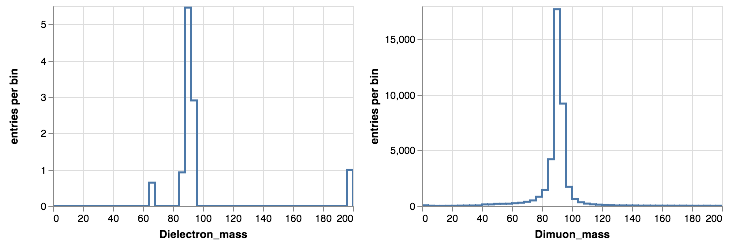

In [4]:


disp = beside(
hist1.step("Dielectron_mass",width=300),
hist2.step("Dimuon_mass",width=300))

display = IPythonDisplay(disp)
display.init()
disp.to(canvas)
